<a href="https://colab.research.google.com/github/DEli-26/DS_Practicum/blob/main/08_resources/deli_proj_pract_08_resources_v2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font size=6><b>**Я.Практикум. Проект №8**</b></font>
    
<font size=6><b>**Выбор локации для скважины**</b></font>

***

# Постановка задачи
**Заказчик:** 
Добывающая компания «ГлавРосГосНефть».

**Цель:** 
Провести расчет прибыли и определить наиболее подходящую локацию для новой скважины.

**Задачи:** 
1. провести EDA;
1. построить три модели для каждого региона, определяющие в каком из них добыча принесет наибольшую прибыль;
1. выбрать скважины с самыми высокими значениями оценок;
1. определить возможную прибыль и риски техникой Bootstrap.

**Исходные данные:** 
Пробы нефти в трёх регионах и характеристики для каждой скважины в регионе. 
Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
Бюджет на разработку скважин в регионе — 10 млрд рублей.
При нынешних ценах один баррель сырья приносит 450 рублей дохода. 
Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. 
Среди них выбирают регион с наибольшей средней прибылью.
Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

# Exploratory Data Analysis

## Подготовка окружения

Загрузим библиотеки, необходимые для выполнения проекта

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

try:
    import phik
except: 
    ! pip install phik
    import phik

# Темная тема графиков
plt.style.use('dark_background')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 690 kB 8.5 MB/s 


## Загрузка данных

Загрузим сами данные.

In [2]:
! gdown --id XXX ! gdown --id XXX ! gdown --id XXX 

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=XXX
To: /content/geo_data_0.csv
100% 8.21M/8.21M [00:00<00:00, 35.5MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=XXX
To: /content/geo_data_1.csv
100% 8.03M/8.03M [00:00<00:00, 68.2MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=XXX
To: /content/geo_data_

In [3]:
df_0 = pd.read_csv('/content/geo_data_0.csv')
df_1 = pd.read_csv('/content/geo_data_1.csv')
df_2 = pd.read_csv('/content/geo_data_2.csv')

Вызовем первые 5 строк и общую информацию о таблицах.

In [4]:
df_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [5]:
df_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [6]:
df_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [7]:
df_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [8]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [9]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


В загруженных данных содержаться следующие столбцы:

* id — уникальный идентификатор скважины;
* f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
* product — объём запасов в скважине (тыс. баррелей).

В каждой таблице содержаться по 100 000 объектов.

Проверим наличие полных дубликатов в таблицах.

In [10]:
df_0.duplicated().sum(), df_1.duplicated().sum(), df_2.duplicated().sum()

(0, 0, 0)

Полные дубликаты отсутствуют.

Cтолбец 'id' не пригодится для решения поставленных задач, а значит, его можно удалить

In [11]:
df_0 = df_0.drop(columns=['id'])
df_1 = df_1.drop(columns=['id'])
df_2 = df_2.drop(columns=['id'])

<div class="alert alert-success">
<b> ✔️ Комментарий ревьювера:</b> Данные загружены успешно! Хорошо что проверил наличие пропусков и дубликатов.

</div>

## Распределения значений в таблицах

Построим гистограммы распределения значений в каждом столбце таблицы.

In [12]:
features = ['f0', 'f1', 'f2', 'product']
def hists(df, n):
    _, axs = plt.subplots(1, len(features), figsize=(24, 4))

    for i in range(len(features)):
        axs[i].hist(df[features[i]], bins=51)
        axs[i].set_xlabel(f'Признак {features[i]}')
        axs[i].set_ylabel("Количество значений")
        axs[i].grid(True)
    plt.suptitle(f'Гистограммы распределения признаков в регионе №{n}')
    plt.show()

<div class="alert alert-success">
<b> ✔️ Комментарий ревьювера:</b> Здорово, что используешь функцию для вывода гистограмм, это уменьшает вероятность ошибки.
</div>

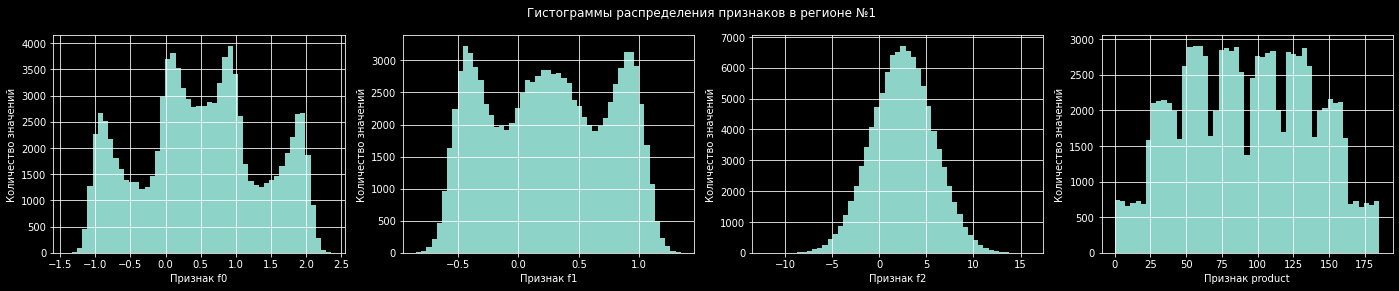

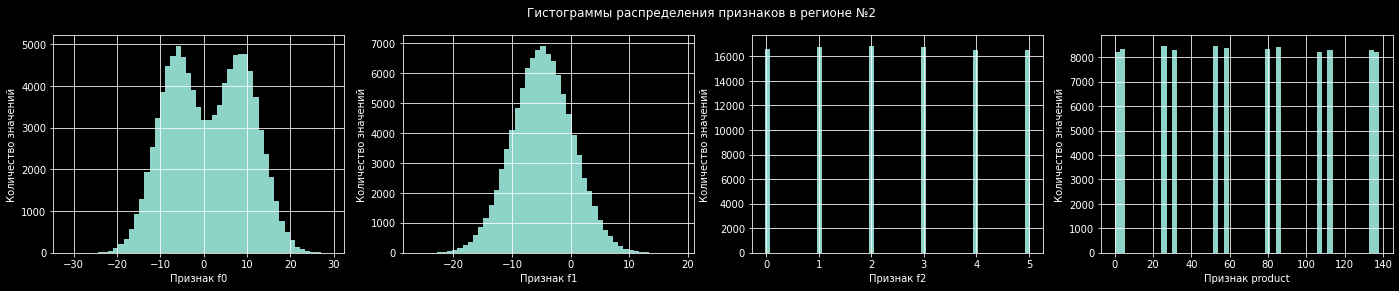

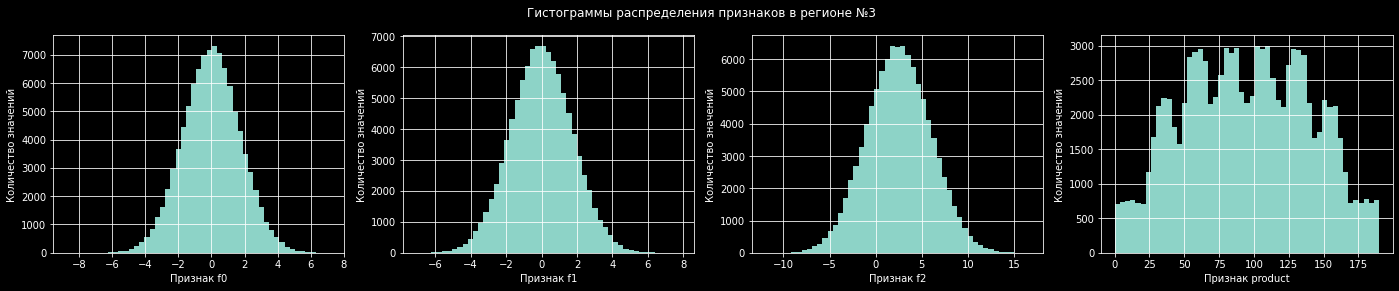

In [13]:
hists(df_0, 1)
hists(df_1, 2)
hists(df_2, 3)

По построенным гистограммам хорошо видно, что рассматриваемые признаки имеют различные диапазоны значений от региона к региону.
При этом, в регионе №3 распределения признаков ближе всех остальных к нормальным.
Признаки 'f0' и 'f1' в регионе №1, а также признак 'f0' в регионе №2 имеют скопления у наиболее часто встречающихся значений. 
А признаки 'f2' и 'product' носят дискретный характер и распределены равномерно.
Полученные распределения могут быть обусловлены, как инструментальными особенностями получения данных, так и различной физической природой признаков для каждого региона.

Несмотря на полученные различия распределений признаков, целевой признак 'product' лежит в одном диапазоне значений.

Учитывая, что диапазон значений каждого признака различный, а модель линейной регрессии чувствительна к ним, целесообразно выполнить нормировку при помощи метода 'MinMaxScaler'.

In [14]:
def scaler_mms(df):
    scaler_mms = MinMaxScaler()
    scaler_mms.fit(df[['f0', 'f1', 'f2']])
    df[['f0', 'f1', 'f2']] = scaler_mms.transform(df[['f0', 'f1', 'f2']])

In [15]:
scaler_mms(df_0)
scaler_mms(df_1)
scaler_mms(df_2)

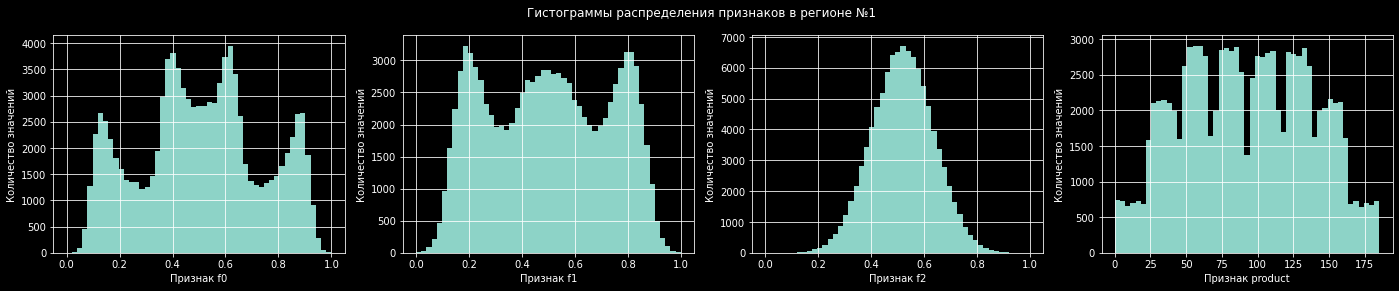

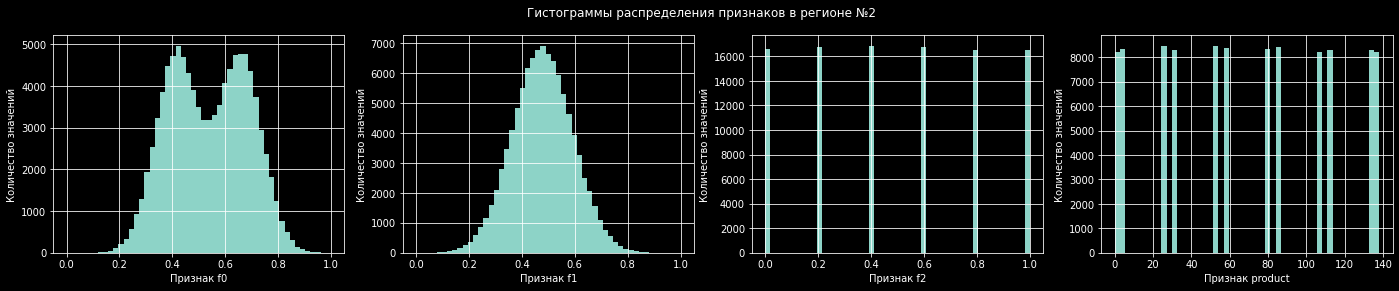

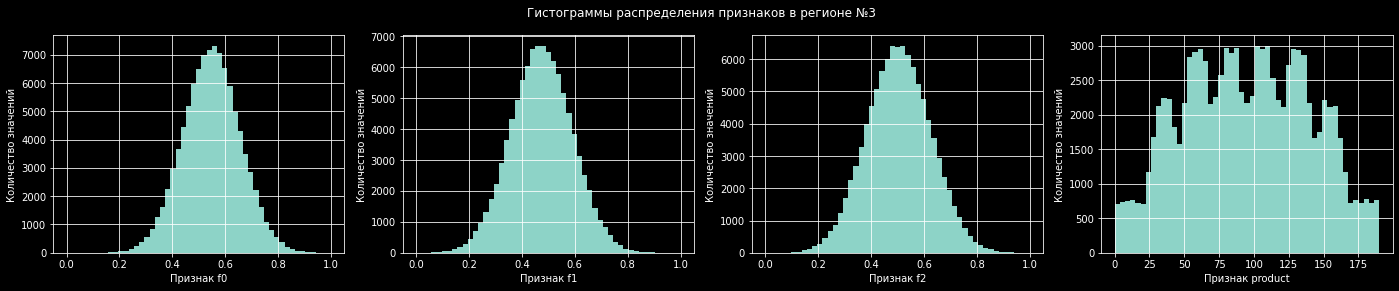

In [16]:
hists(df_0, 1)
hists(df_1, 2)
hists(df_2, 3)

По гистограммам видно, что нормировка выполнена успешно.

## Определение взаимосвязей признаков 

Определим наличие взаимосвязей между данными в разных столбцах. Для этого используем библиотеку phik, которая определяет нелинейные взаимосвязи.

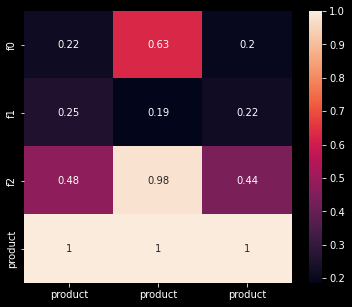

In [17]:
plt.figure(figsize=(6, 5))
sns.heatmap(pd.concat([
    df_0.phik_matrix(interval_cols=features, dropna=False)[['product']],
    df_1.phik_matrix(interval_cols=features, dropna=False)[['product']],
    df_2.phik_matrix(interval_cols=features, dropna=False)[['product']],
],
                      axis=1),
            annot=True)
plt.show()

Для первого и третьего регионов взаимосвязи признаков практические не отличаются. 
Однако для второго региона коэффициент корреляции признака 'f2' и целевого признака 'product' равен 0,98, что означает их практически полное повторение. 
По всей видимости, это может быть вызвано обнаруженной ранее дискретностью величин.
Использование признака 'f2' для построения модели не целесообразно, так как он содержит в себе ответы, что повлечет за собой переобучение.
При сборе последующих данных такая взаимосвязь может быть нарушена, что повлечет за собой неверные предсказания модели.

## Заключение по EDA

Загружены данные о пробах нефти в трех регионах - по одной таблице для каждого региона. 
В каждой таблице содержаться значения для 100 000 скважин.

Распределение величин признаков для каждого региона уникальное. 
При этом наблюдается скопление у определенных значений и дискретность некоторых из них.
Для каждого региона диапазон значений признаков так же уникальный. 
В этой связи, для повышения точности предсказания линейной регрессией, выполнено нормирование значений к диапазону [0, 1].

Рассмотрены взаимосвязи признаков. 
Коэффициент корреляции признака 'f2' и целевого признака 'product' равен 0,98, что может вызвать переобучение при использовании модели линейной регрессии.

# Моделирование

## Подготовка выборок

Перед разбиением выборок сохраним признаки в отдельные переменные.

In [18]:
X = ['f0', 'f1', 'f2']
y = ['product']

Разобьем исходные таблицы на обучающие и валидационные выборки.

In [19]:
df_0_train, df_0_valid, df_1_train, df_1_valid, df_2_train, df_2_valid = train_test_split(
    df_0, df_1, df_2, test_size=.25, random_state=26)

Проверим результат разбиения анализом размеров таблиц.

In [20]:
df_0.shape, df_0_train.shape, df_0_valid.shape

((100000, 4), (75000, 4), (25000, 4))

Разбиение выполнено успешно.

## Обучение моделей

Создадим функцию, которая обучает модели на тестовой выборке, предсказывает и возвращает значения по валидационной выборке, а также рассчитывает RMSE.

In [21]:
def modeling(df_train, df_valid, features, n):
    model = LinearRegression()
    model.fit(df_train[features], df_train[y])
    predictions = model.predict(df_valid[features])
    rmse = mean_squared_error(df_valid[y], predictions, squared=False)
    print(f'Средний запас предсказанного сырья для региона №{n}: {round(predictions.mean(), 1)}; RMSE модели: {round(rmse, 1)}')
    return predictions

In [22]:
df_0_valid['product_pred'] = modeling(df_0_train, df_0_valid, X, 1) 
df_1_valid['product_pred'] = modeling(df_1_train, df_1_valid, X, 2)
df_2_valid['product_pred'] = modeling(df_2_train, df_2_valid, X, 3)

Средний запас предсказанного сырья для региона №1: 92.4; RMSE модели: 37.8
Средний запас предсказанного сырья для региона №2: 68.8; RMSE модели: 0.9
Средний запас предсказанного сырья для региона №3: 94.8; RMSE модели: 40.3


В среднем, больше всего сырья в регионе №3. 
Наименьшее значение корня из среднеквадратической ошибки (RMSE) получено для 2го региона, что объясняется высоким коэффициентом корреляции, полученным ранее.

## Заключение по моделированию

Исходные данные разделены на обучающие и валидационные выборки в пропорции 3:1 соответственно.
Разработаны модели линейной регрессии для каждого региона и определен по ним запас сырья.

Получено, что во втором регионе запасов меньше всего - в среднем 68,8 тыс. баррелей. 
При этом корень из среднеквадратической ошибки (RMSE) составляет 0,9 тыс. баррелей.
Такой результат обусловлен высокой корреляцией признака 'f2' с целевым признаком.

Средний запас предсказанного сырья для регионов №1 и №3 составляет 92,4 и 94,8 тыс. бареллей соответственно с RMSE 37,8 и 40,8 тыс. баррелей.

# Расчет прибыли

## Подготовка данных

Сохраним в отдельных переменных ключевые значения для расчётов.

In [23]:
COUNT_INVESTIGATED = 500  # количество исследуемых месторождений
COUNT_BEST = 200          # количество разрабатываемых месторождений
BUDGET = 10e9             # бюджет
INCOME_PER_PROD = 450e3   # доход с одной тысячи баррелей продукта
PROB_LOSS_MAX = 2.5       # допустимый процент вероятности убытков

Рассчитаем достаточный объем продукта для безубыточной разработки новой скважины. 

In [24]:
BUDGET / INCOME_PER_PROD / COUNT_BEST

111.11111111111111

Полученное значение примерно на 15% больше среднего запаса предсказанного сырья для региона №3.
Таким образом, риск получения убытка значителен.
Для оценки его уровня рассчитаем максимальную прибыль и применим технику bootstrap. 

## Расчет максимальной прибыли

Расчет максимальной прибыли выполним при помощи функции, которая выбирает 200 скважин с максимальными значениями предсказаний.
Затем суммирует действительное значение объема сырья, соответствующее этим предсказаниям, и вычисляет саму прибыль (в млрд. руб.).

In [25]:
def income_calc(df):
    prod_pred_sum = df.sort_values(by=['product_pred'], ascending=False).head(count_best)['product'].sum()
    income = income_per_prod * prod_pred_sum - budget
    return income/1e9

In [26]:
income_calc(df_0_valid), income_calc(df_1_valid), income_calc(df_2_valid)

(2.9936217007944586, 2.4150866966815108, 2.49966450993807)

Максимальная прибыль может быть получена для 1го региона и составляет почти 3 млрд. руб.
Для региона №3 аналогичный показатель составляет 2,5 млрд. руб., а для региона №2 уже 2,1 млрд. руб.

Следует отметить, что полученные значения соответствуют разработке скважин с максимальными запасами продукта.
Однако такое событие крайне маловероятно.
В связи с чем необходимо применить технику Bootstrap, которая, в соответствии с законом больших чисел, поможет определить диапазон реальной прибыли и количественно оценить риск получения убытков.

## Расчет рисков и прибыли для каждого региона

Применим технику Bootstrap с 1000 выборок, чтобы найти среднюю прибыль, 95%-й доверительный интервал и риск убытков. Для этого создадим соответствующую функцию.

In [27]:
def bootstrep(df, n):
    values = []
    state = np.random.RandomState(26)
    
    for i in range(1000):
        df_sample = df.sample(n=count_investigated, replace=True, random_state=state)
        values.append(income_calc(df_sample))
        
    values = pd.Series(values)

    income_mean = round(values.mean(), 2)
    conf_interval = round(values.quantile(.025), 3), round(values.quantile(.975), 3)
    prob_loss = round(values[values < 0].count() / len(values) * 100, 2)
    plt.hist(values, bins=20)
    plt.xlabel(xlabel='Прибыль, млрд. руб.')
    plt.ylabel('Количество значений')
    plt.title(f'Распределение прибыли для региона №{n}')
    plt.show()
    print(f'Средняя прибыль: {income_mean} млрд. руб., 95%-й интервал: {conf_interval} млрд. руб., а риск убытков: {prob_loss}%')
    if prob_loss > prob_loss_max:
        print('Риск убытков БОЛЬШЕ порогового значения!!!')

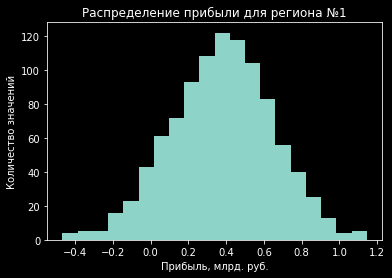

Средняя прибыль: 0.38 млрд. руб., 95%-й интервал: (-0.161, 0.897) млрд. руб., а риск убытков: 8.5%
Риск убытков БОЛЬШЕ порогового значения!!!


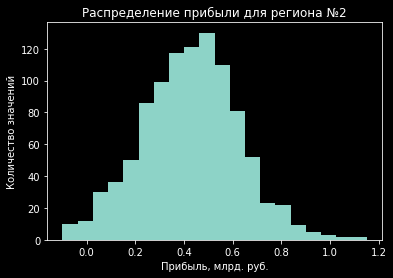

Средняя прибыль: 0.43 млрд. руб., 95%-й интервал: (0.037, 0.812) млрд. руб., а риск убытков: 1.7%


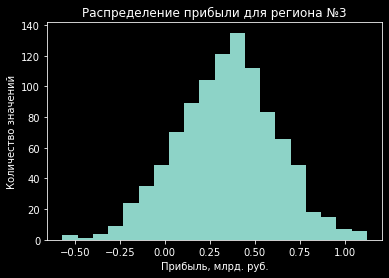

Средняя прибыль: 0.34 млрд. руб., 95%-й интервал: (-0.193, 0.89) млрд. руб., а риск убытков: 10.6%
Риск убытков БОЛЬШЕ порогового значения!!!


In [28]:
bootstrep(df_0_valid, 1)
bootstrep(df_1_valid, 2)
bootstrep(df_2_valid, 3)

## Заключение по расчету прибыли


Разработаны функции для расчета прибыли и рисков. 

Согласно произведенным расчетам получено, что для безубыточной разработки 200 скважин, их средний запас продукта должен быть не менее 111.1 тыс. баррелей. 
Учитывая, что средний запас продукта в регионе меньше указанного значения, это создает существенную вероятность для получения убытков.

Для определения диапазона реальной прибыли и количественной оценки риска получения убытков применена техника Bootstrap.
Полученные значения сведены в таблицу.

|Параметр|Регион №1|Регион №2|Регион №3|
|--------|---------|---------|---------|
|Диапазон прибыли (95%), млрд. руб.|[-0,16, 0,9]|[0,04, 0,81]|[-0,19, 0,89]|
|Средняя прибыль, млрд. руб.|0,38|0,43|0,34|
|Риск убытков, %|8,5|1,7|10,6|

Из представленных значений хорошо видно, что при разработке региона №2 прибыль, в среднем, имеет максимальное значение.
В то же время, риск убытков в этом регионе минимальный.
Такие результаты обусловлены точными предсказаниями модели линейной регрессии.

# Выводы
В ходе выполненной работы рассмотрены данные о пробах нефти в трех регионах - по одной таблице для каждого региона. 
Исследованы распределение величин признаков для каждого региона и взаимосвязи признаков. 
Получен коэффициент корреляции признака 'f2' и целевого признака 'product', равный 0,98.

Разработаны модели линейной регрессии для каждого региона и определен по ним запас сырья.
Средний запас предсказанного сырья для регионов №1 и №3 составляет 92,4 и 94,8 тыс. баррелей соответственно.
Во втором регионе запасов меньше всего - в среднем 68,8 тыс. баррелей. 
Однако для безубыточной разработки 200 скважин, их средний запас продукта должен быть не менее 111.1 тыс. баррелей.
Таким образом, существенным является риск получения убытков.

Для определения диапазона реальной прибыли и количественной оценки риска получения убытков применена техника Bootstrap на выборке из 1000 значений прибыли.
Согласно проведенным расчетам, при разработке региона №2 прибыль, в среднем, имеет максимальное значение и составляет 0,43 млрд. руб.
При этом 95%-й интервал прибыли лежит в диапазоне от 0,04 до 0,81 млрд. руб., а риск получения убытков не превосходит 1,7%. 
Для регионов №1 и №3, несмотря на большие запасы продукта, получены значения риска получения убытков 8,5% и 10,6% соответственно, что больше установленного порога в 2,5%

Такие результаты обусловлены точными предсказаниями модели для региона №2, что проявляется в значении RMSE, равном 0,9 тыс. баррелей.
Последний, в свою очередь, обусловлен высоким коэффициентом корреляции между признаками 'f2' и 'product'.

Учитывая изложенное, наиболее перспективным регионом для разработки новых скважин является регион №2.